In [70]:
import astropy.units as units
import astropy.constants as constants
import matplotlib.pyplot as plt
import sympy as sym
import numpy as np 
import pandas as pd
import plotly.express as px
import requests
import plotly.graph_objects as go
a, b, c, d, e, f, g, h, i, j, k, l, m = sym.symbols('a b c d e f g h i j k l m')
n, o, p, q, r, s, t, u, v, w, x, y, z = sym.symbols('n o p q r s t u v w x y z')
symbol_list = (a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v,
w, x, y, z)
A, B, C, D, E, F, G, H, I, J, K, L, M = sym.symbols('A B C D E F G H I J K L M')
N, O, P, Q, R, S, T, U, V, W, X, Y, Z = sym.symbols('N O P Q R S T U V W X Y Z')
symbol_list = (A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, 
               V, W, X, Y, Z)
#%matplotlib notebook #incompatible with mpmath

#Import half-lifes and energy per emission from databases
[Zotero Collection](https://www.zotero.org/groups/4549380/batteries/collections/59RQX9TX) / [Atomic Mass Data Center (AMDC)](https://www-nds.iaea.org/amdc/)



##Nubase2020


In [71]:
url = "https://www-nds.iaea.org/amdc/ame2020/nubase_3.mas20.txt"
response = requests.get(url)
nubase = np.array(response.text.split('\n'))
nubase = nubase[25:]
column_dict = {'AAA': np.arange(1,4), 'ZZZi':np.arange(5,9),
'A El': np.arange(11,17), 's': np.array([17]), 
'Mass #': np.arange(19,32), 'dMass #': np.arange(32,43),
'Exc #': np.arange(43,55), 'dE #': np.arange(55,66),
'Orig': np.arange(66,68), 'Isom.Unc': np.array([68]),
'Isom.Inv': np.array([69]), 'T #': np.arange(70, 79),
'unit T': np.arange(79, 81), 'dT': np.arange(81, 89),
'Jpi */#/T=': np.arange(88, 103), 
'Ensdf year': np.arange(102, 105), 
'Discovery': np.arange(114, 119), 'BR': np.arange(119, 210)}
#make an array of lists of the columns

def clean(array):
    #turn the array of characters into a string and remove spaces
    array = ''.join(array).replace(' ', '')
    try:
        array = array.astype(float)
    except:
        pass
    return array

#Turn the list of strings into a multidimensional array


In [72]:
#get substring from each item in array
def get_substring(array, start, end):
    #start and end are the indices of the substring
    #returns a list of the substring
    try:
        return [item[start:end] for item in array]
    except:
        print(len(item), end)
        return ("error")

def make_dict_from_string_array(column_dict, string_array):
    #column_dict is a dictionary of the column names and the indices
    #string_array is a list of strings
    #returns a dictionary of the column names and the values
    nubase_dict = {}
    for key, columns in column_dict.items():
        nubase_dict[key] = get_substring(string_array, columns[0], columns[-1])
    return nubase_dict

nubase_df = pd.DataFrame(make_dict_from_string_array(column_dict, nubase))
nubase_df

,AAA,ZZZi,A El,s,Mass #,dMass #,Exc #,dE #,Orig,Isom.Unc,Isom.Inv,T #,unit T,dT,Jpi */#/T=,Ensdf year,Discovery,BR
0,01,000,1n,,8071.3181,0.0004,,,,,,609.8,s,0.6,1/2+*,06,1932,B-=100
1,01,010,1H,,7288.971064,0.000013,,,,,,stbl,,,1/2+*,06,1920,IS=99.9855 78
2,02,010,2H,,13135.722895,0.000015,,,,,,stbl,,,1+*,03,1932,IS=0.0145 78
3,03,010,3H,,14949.81090,0.00008,,,,,,12.32,y,0.02,1/2+*,00,1934,B-=100
4,03,020,3He,,14931.21888,0.00006,,,,,,stbl,,,1/2+*,98,1934,IS=0.0002 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,93,180,293Og,,98800#,710#,,,N,,,1#,s,,,00,2010,A ?
5840,94,170,294Ts,,96400#,590#,,,,,,70,s,30,,19,2010,A=100
5841,94,180,294Og,,99320#,550#,,,,,,0.7,s,0.3,0+,05,2004,A~100; SF ?
5842,95,180,295Og,,01370#,660#,,,,,,680,s,540,,,2006,A~100


In [73]:
nubase_df.to_csv('nubase_df.csv')
        

##AME2020

In [74]:
url = "https://www-nds.iaea.org/amdc/ame2020/mass_1.mas20.txt"
response = requests.get(url)
Atomic_mass_table_2020 = response.text
#Now we want to convert a string to a pandas dataframe
Atomic_mass_table_2020 = list(Atomic_mass_table_2020.split('\n'))
split_table = Atomic_mass_table_2020[36:]

def clean_uncertainty(uncertainty):
    uncertainty = uncertainty.replace('.', '')
    uncertainty = uncertainty.replace('a', '0')
    uncertainty = uncertainty.replace('#', '')
    uncertainty = float("0." + uncertainty)
    return uncertainty

def clean_row(row):
    while True:
        try:
            row[2] = int(row[2])
            number = row.pop(0)
        except:
            row.insert(0, number)
            break
    #The above while loop ensures the first column is the number of neutrons
    try: 
        row[4] = float(row[4]) #if this fails, we the row is valid
        row.insert(4, "NA")
    except:
        pass
    try:
        row[10] = row[10].replace('#', '')
        row[10] = float(row[10]) #This means element 9 is *
    except:
        row.insert(11, "NA")
    #if not (len(row) == 15):
    #    print(row, len(row), row[9])
    #print(len(row), row)
    row[12] = float(row[12]) + clean_uncertainty(row[13])
    #this number was formatted weirdly, so we need to clean it up
    row.pop(13)
    
    return row

for i in range(len(split_table)):
    try:
        split_table[i] = clean_row(split_table[i].split())
    except:
        print(split_table[i].split())
#We know the column names are on row 34 (0-indexed)
#now we will make a pandas dataframe from the list of rows
#Annoyingly, the column names don't include the uncertainties, so we need to add them
my_column_names = ["N", "Z", "A", "Elt.", "Orig.", "Mass excess (keV)", "Mass excess (uncertainty)",
 "Binding energy per nucleon (keV)", "Binding energy per nucleon (uncertainty)", 
 "Beta-decay Type", "Beta-decay energy (keV)", 
 "Beta-decay energy (uncertainty)", "Atomic mass (μu)", 
 "Atomic mass (uncertainty)"]
Atomic_mass_table_2020 = pd.DataFrame(split_table, columns = my_column_names)

[]


In [75]:
Atomic_mass_table_2020

,N,Z,A,Elt.,Orig.,Mass excess (keV),Mass excess (uncertainty),Binding energy per nucleon (keV),Binding energy per nucleon (uncertainty),Beta-decay Type,Beta-decay energy (keV),Beta-decay energy (uncertainty),Atomic mass (μu),Atomic mass (uncertainty)
0,1,0.0,1.0,n,NA,8071.31806,0.00044,0.0,0.0,B-,782.347,0.0004,1.008665,0.00047
1,0,1.0,1.0,H,NA,7288.971064,0.000013,0.0,0.0,B-,*,NA,1.007825,0.000014
2,1,1.0,2.0,H,NA,13135.722895,0.000015,1112.2831,0.0002,B-,*,NA,2.014102,0.000015
3,2,1.0,3.0,H,NA,14949.8109,0.00008,2827.2654,0.0003,B-,18.59202,0.00006,3.016049,0.00008
4,1,2.0,3.0,He,NA,14931.21888,0.00006,2572.68044,0.00015,B-,-13736.0,2000#,3.016029,0.00006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3554,175,118.0,293.0,Og,-a,198802#,709#,7078#,2#,B-,*,NA,293.213423,761#
3555,177,117.0,294.0,Ts,-a,196397#,593#,7092#,2#,B-,-2923.0,811#,294.210840,637#
3556,176,118.0,294.0,Og,-a,199320#,553#,7079#,2#,B-,*,NA,294.213979,594#
3557,177,118.0,295.0,Og,-a,201369#,655#,7076#,2#,B-,*,NA,295.216178,703#


In [76]:
#Now we want to write the dataframe to a csv file
Atomic_mass_table_2020.to_csv("Atomic_mass_table_2020.csv")

##Half-life vs. Beta Emission

In [77]:
AM_table = Atomic_mass_table_2020
'''
First we will convert the atomic mass numbers to integers then concatenate them
with their chemical symbol. 
'''
def concat_add_space(a, b):
  try: 
    a = int(a)
  except:
    a = 0
  return (str(a) + " " + str(b))


AM_table['A Elt.'] = [concat_add_space(A, AM_table['Elt.'][row]) for row, A 
                 in enumerate(AM_table['A'])]

In [78]:
chemical_symbols = AM_table['A Elt.']

units_dict = {'s': units.s, 'h': units.h, 'd': units.d, 'm' : units.minute, 
              'y': units.year}

def convert_half_life(number, unit, units_dict):
  try: 
    half_life = float(number) * units_dict[unit].to(units.year)
  except: #isotope is stable
    half_life = 'unknown'
  return half_life

def remove_symbols(string, symbol_list):
  for symbol in symbol_list:
    string = string.replace(symbol, "")
  return string

sym_list = [" ", "#", "*"]

half_lives_seconds = [convert_half_life(remove_symbols(t, sym_list), 
                    remove_symbols(nubase_df['unit T'][row], sym_list), 
                    units_dict) for row, t in enumerate(nubase_df['T #'])]
nubase_df['T in s'] = half_lives_seconds

In [79]:
#Now we will find which nuclides are in both datasets
AM_table['A Elt.'] = [symbol.replace(" ","") for symbol in AM_table['A Elt.']]
AM_table['A Elt.']
#overlapping_nuclid

0          1n
1          1H
2          2H
3          3H
4         3He
        ...  
3554    293Og
3555    294Ts
3556    294Og
3557    295Og
3558    0None
Name: A Elt., Length: 3559, dtype: object

In [80]:
#Now we will find which nuclides are in both datasets
nubase_df['A El'] = [symbol.replace(" ","") for symbol in nubase_df['A El']]
nubase_df['A El']
#overlapping_nuclid

0          1n
1          1H
2          2H
3          3H
4         3He
        ...  
5839    293Og
5840    294Ts
5841    294Og
5842    295Og
5843         
Name: A El, Length: 5844, dtype: object

In [81]:
intersection = set(nubase_df['A El']) & set(AM_table['A Elt.'])
intersection
#the nuclides in nubase are a subset of those in AM

{'71As',
 '29Na',
 '53V',
 '111Tc',
 '25Ne',
 '164Hf',
 '289Fl',
 '224At',
 '128Ba',
 '155La',
 '215Ac',
 '127Cd',
 '98Ag',
 '59Fe',
 '37K',
 '162Re',
 '173Os',
 '157Yb',
 '54V',
 '145Ba',
 '240Es',
 '86Tc',
 '168Er',
 '192At',
 '294Ts',
 '84Zr',
 '184W',
 '46Cl',
 '99Tc',
 '243Fm',
 '99Kr',
 '68Kr',
 '188Hg',
 '226Th',
 '273Sg',
 '161Tb',
 '107Pd',
 '203Tl',
 '42P',
 '100Pd',
 '172Lu',
 '195Rn',
 '167Ta',
 '170Re',
 '68Br',
 '66Ge',
 '45Ca',
 '122I',
 '98Pd',
 '208Ac',
 '60Ga',
 '123I',
 '126Rh',
 '165Os',
 '188W',
 '259Rf',
 '214Ra',
 '286Nh',
 '177Tm',
 '214Ac',
 '17O',
 '134Ba',
 '227At',
 '152Er',
 '235Cm',
 '47S',
 '285Nh',
 '67Cr',
 '166Gd',
 '174Lu',
 '11Li',
 '195Po',
 '75Cu',
 '289Mc',
 '239Th',
 '84Rb',
 '118Ag',
 '91Sr',
 '45S',
 '167Os',
 '66Co',
 '202Bi',
 '137Tb',
 '175Yb',
 '87Nb',
 '151Pr',
 '67V',
 '230Th',
 '48Fe',
 '245Pu',
 '194Re',
 '105Te',
 '105Ru',
 '194Os',
 '188Au',
 '183Ta',
 '97Rb',
 '99Y',
 '236Ac',
 '77Ge',
 '126Te',
 '110In',
 '209Hg',
 '27Ne',
 '130Te',

In [82]:
#Now we want the beta decay energy for every nuclide in nubase
AM_table['Beta-decay energy (keV)']

0        782.347
1              *
2              *
3       18.59202
4       -13736.0
          ...   
3554           *
3555     -2923.0
3556           *
3557           *
3558        None
Name: Beta-decay energy (keV), Length: 3559, dtype: object

In [83]:
AM_symbols = list(AM_table['A Elt.'])
nubase_symbols = list(nubase_df['A El'])

In [84]:
AM_rows = [AM_symbols.index(n) for n in
intersection]
nubase_rows = [nubase_symbols.index(n) for
n in intersection]

In [85]:
e_t_dict = {}
e_t_dict['Beta-decay energy (keV)'] = (
AM_table['Beta-decay energy (keV)'][AM_rows])
e_t_dict['Half life (years)'] = (
nubase_df['T in s'][nubase_rows])
#for key, value in e_t_dict.values():
#        print(len(value))
e_t_dict['Isotope'] = list(intersection)

In [86]:
px.scatter(x = e_t_dict['Beta-decay energy (keV)'],
y = e_t_dict['Half life (years)'], 
hover_name = e_t_dict['Isotope'],
labels = {'x': 'Beta-decay energy (keV)',
'y': 'Half life (years)'}, log_y = True)

###Retrieving data from dataframes and dictionaries

In [87]:
def get_isotope_info(isotope, info = None, isotope_column = None,
    dataset = {}, isotope_list = None, list_to_search = []):                  
  '''
  isotope_list and list_to_search are optional arguments.
  If list_to_search is not provided, then info must be provided.
  If isotope_list is not provided, then dataset and isotope_column
  must be provided.
  '''
  if not isotope_list:
    isotope_list = list(dataset[isotope_column])
  row = isotope_list.index(isotope)
  if len(list_to_search) == 0:
    try:
      list_to_search = list(dataset[info])
    except:
      print("info to search for not entered")
      return
  return list_to_search[row]

get_isotope_info('63Ni', 'Half life (years)', 'Isotope', e_t_dict)

101.2

In [88]:
nubase_isotopes = list(nubase_df['A El'])
nubase_br_list = list(nubase_df['BR'])
get_isotope_info('63Ni', isotope_list = nubase_isotopes, dataset = nubase_df,
                 info = 'BR')

'B-=100'

#Calculations for Power vs. Half-life

In [89]:

def half_life_to_energy(half_life, time, initial_mass, decay_type, molar_mass):
    #we assume half life and time have consistent units (e.g. both in seconds)
    #all masses are in grams
    initial_counts = initial_mass * 6.0221408 * (10**23) / molar_mass 
    decay_count = initial_counts * (1-(.5 ** (time / half_life)))    
    energy = decay_energy(decay_count, decay_type) / 2 #conservative estimate
    return (energy) #joules, counts

def decay_energy(decay_counts, decay_type):
  if(decay_type == "beta_minus"):
    return decay_counts * 2.7237003 * (10 ** -15) #Joules

half_life_U_238 = 1.41*(10 ** 17) #seconds 
half_life_CA_48 = 6.4 * (10 ** 26.5) #seconds
#around 10^9.5 years :)
half_life = 10 ** 11
mass = 10 ** -3 #grams
time = 1 #second
power = half_life_to_energy(half_life, time, mass, "beta_minus",                             
            63)
mass, power, time = mass * units.g, power * units.W, time * units.s
print(mass, "generates", power, "and loses", mass,
      "of mass over the first\nsecond :).\n Half of the energy" +
      " will be lost in", (time).to(units.year))

0.001 g generates 9.023273319236257e-08 W and loses 0.001 g of mass over the first
second :).
 Half of the energy will be lost in 3.168808781402895e-08 yr


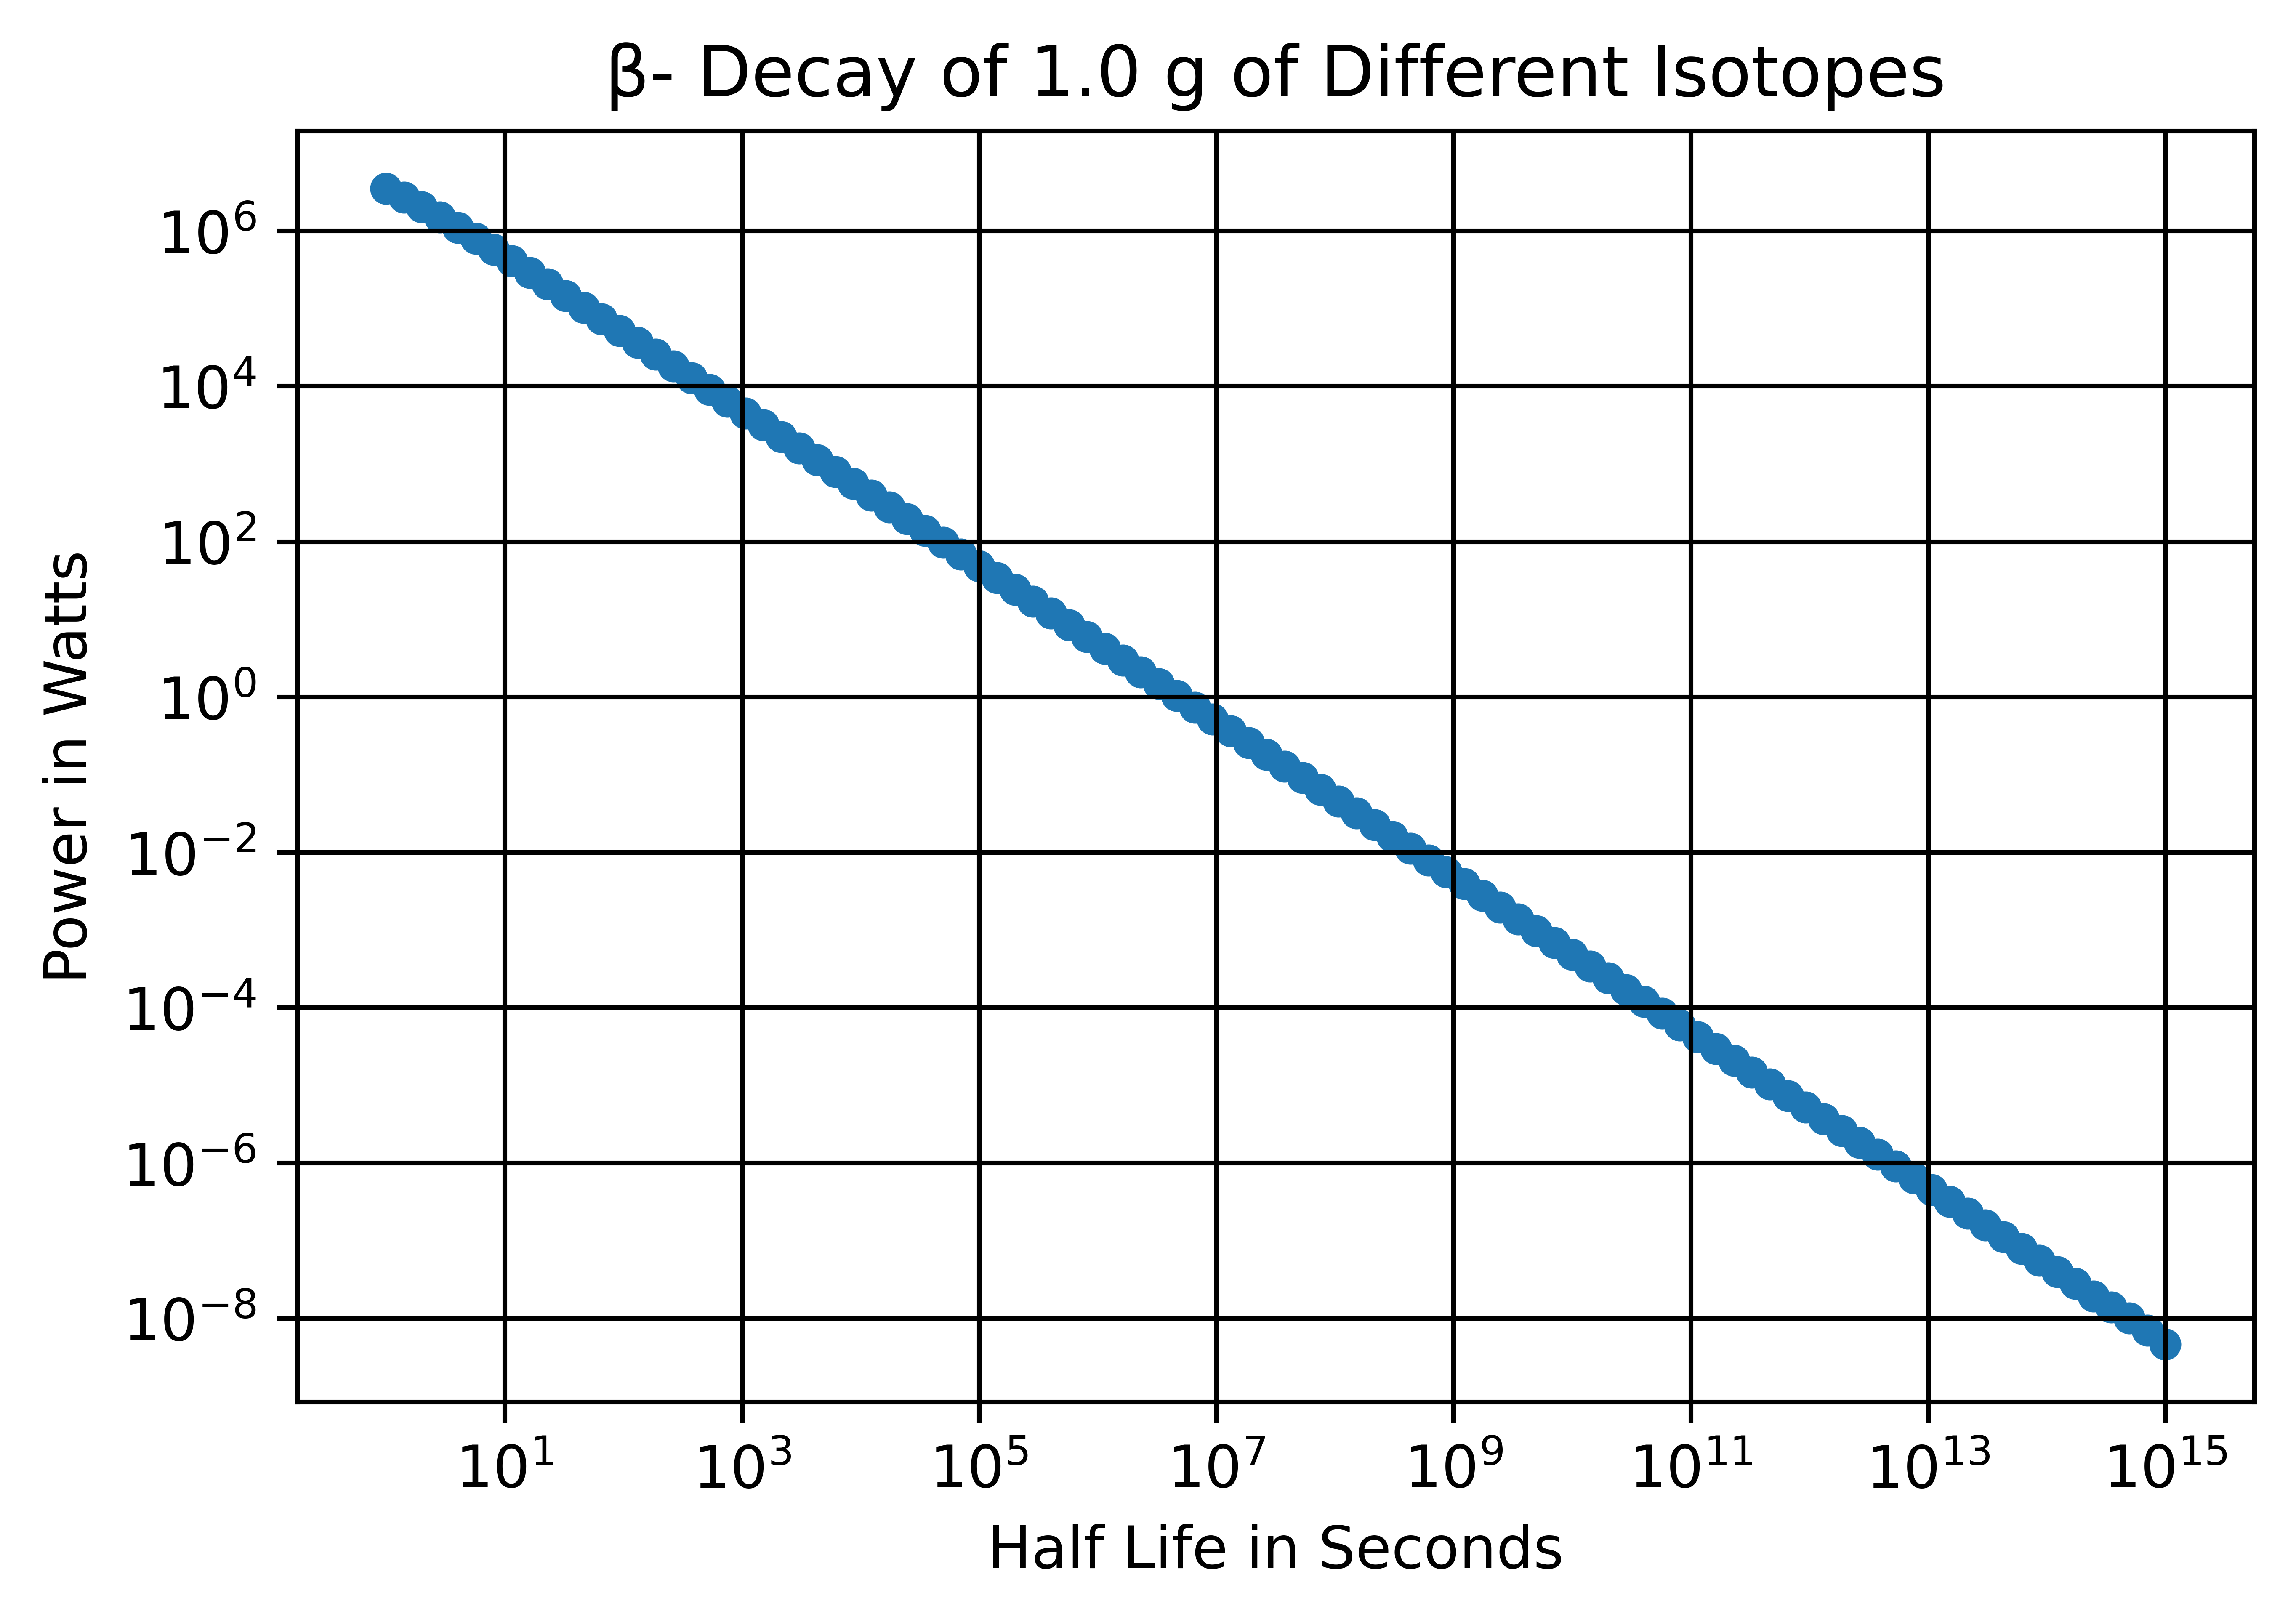

In [90]:
'''
Here we will plot half-life versus power generated in first second of existence.
Based on the plot this makes, since there are about 10^9.5 seconds in a century,
the ideal half life is around 10^10 seconds. This will mean after a century,
it will only half of the remaining mass (and thus presumably only produce half
of the energy indicated in this plot). 

'''
def calc_half_power(min_half_life, max_half_life, steps, mass, molar_mass):
  precise_half_lives, power_array = [], []
  time = 1
  for exponent in np.linspace(min_half_life, max_half_life, steps):
        half_life = 10 ** exponent
        precise_half_lives.append(half_life)
        power = half_life_to_energy(half_life, time, mass, "beta_minus", 
                                    molar_mass)
        power_array.append(power)
  return (precise_half_lives, power_array)

def plot_power_vs_half_life(min_half_life, max_half_life, steps, mass, 
                            molar_mass, point_size, provide_fit, dpi):
  '''
  Note that the half-lifes give are assumed to be a power of 10
  '''
  precise_half_lives, power_array = calc_half_power(min_half_life, 
                                      max_half_life, steps, mass, molar_mass)
  plt.figure(dpi = dpi)
  plt.scatter(x = precise_half_lives, y= power_array, s = point_size)
  plt.xscale("log"), plt.yscale("log")
  plt.title("β- Decay of " + str(mass * units.g) + " of Different Isotopes")
  plt.ylabel("Power in Watts")
  plt.xlabel("Half Life in Seconds")
  plt.grid(which='major', color='black')
  plt.grid(which='minor', color='grey', alpha=0.4)
  plt.minorticks_on()
  logX, logY = np.log10(precise_half_lives), np.log10(power_array)
  plt.show()
  if provide_fit:
    return np.polyfit(logX, logY, 1)
plot_power_vs_half_life(0, 15, 100, 1, 118, point_size = 20, 
                        provide_fit = False, dpi = 1000)


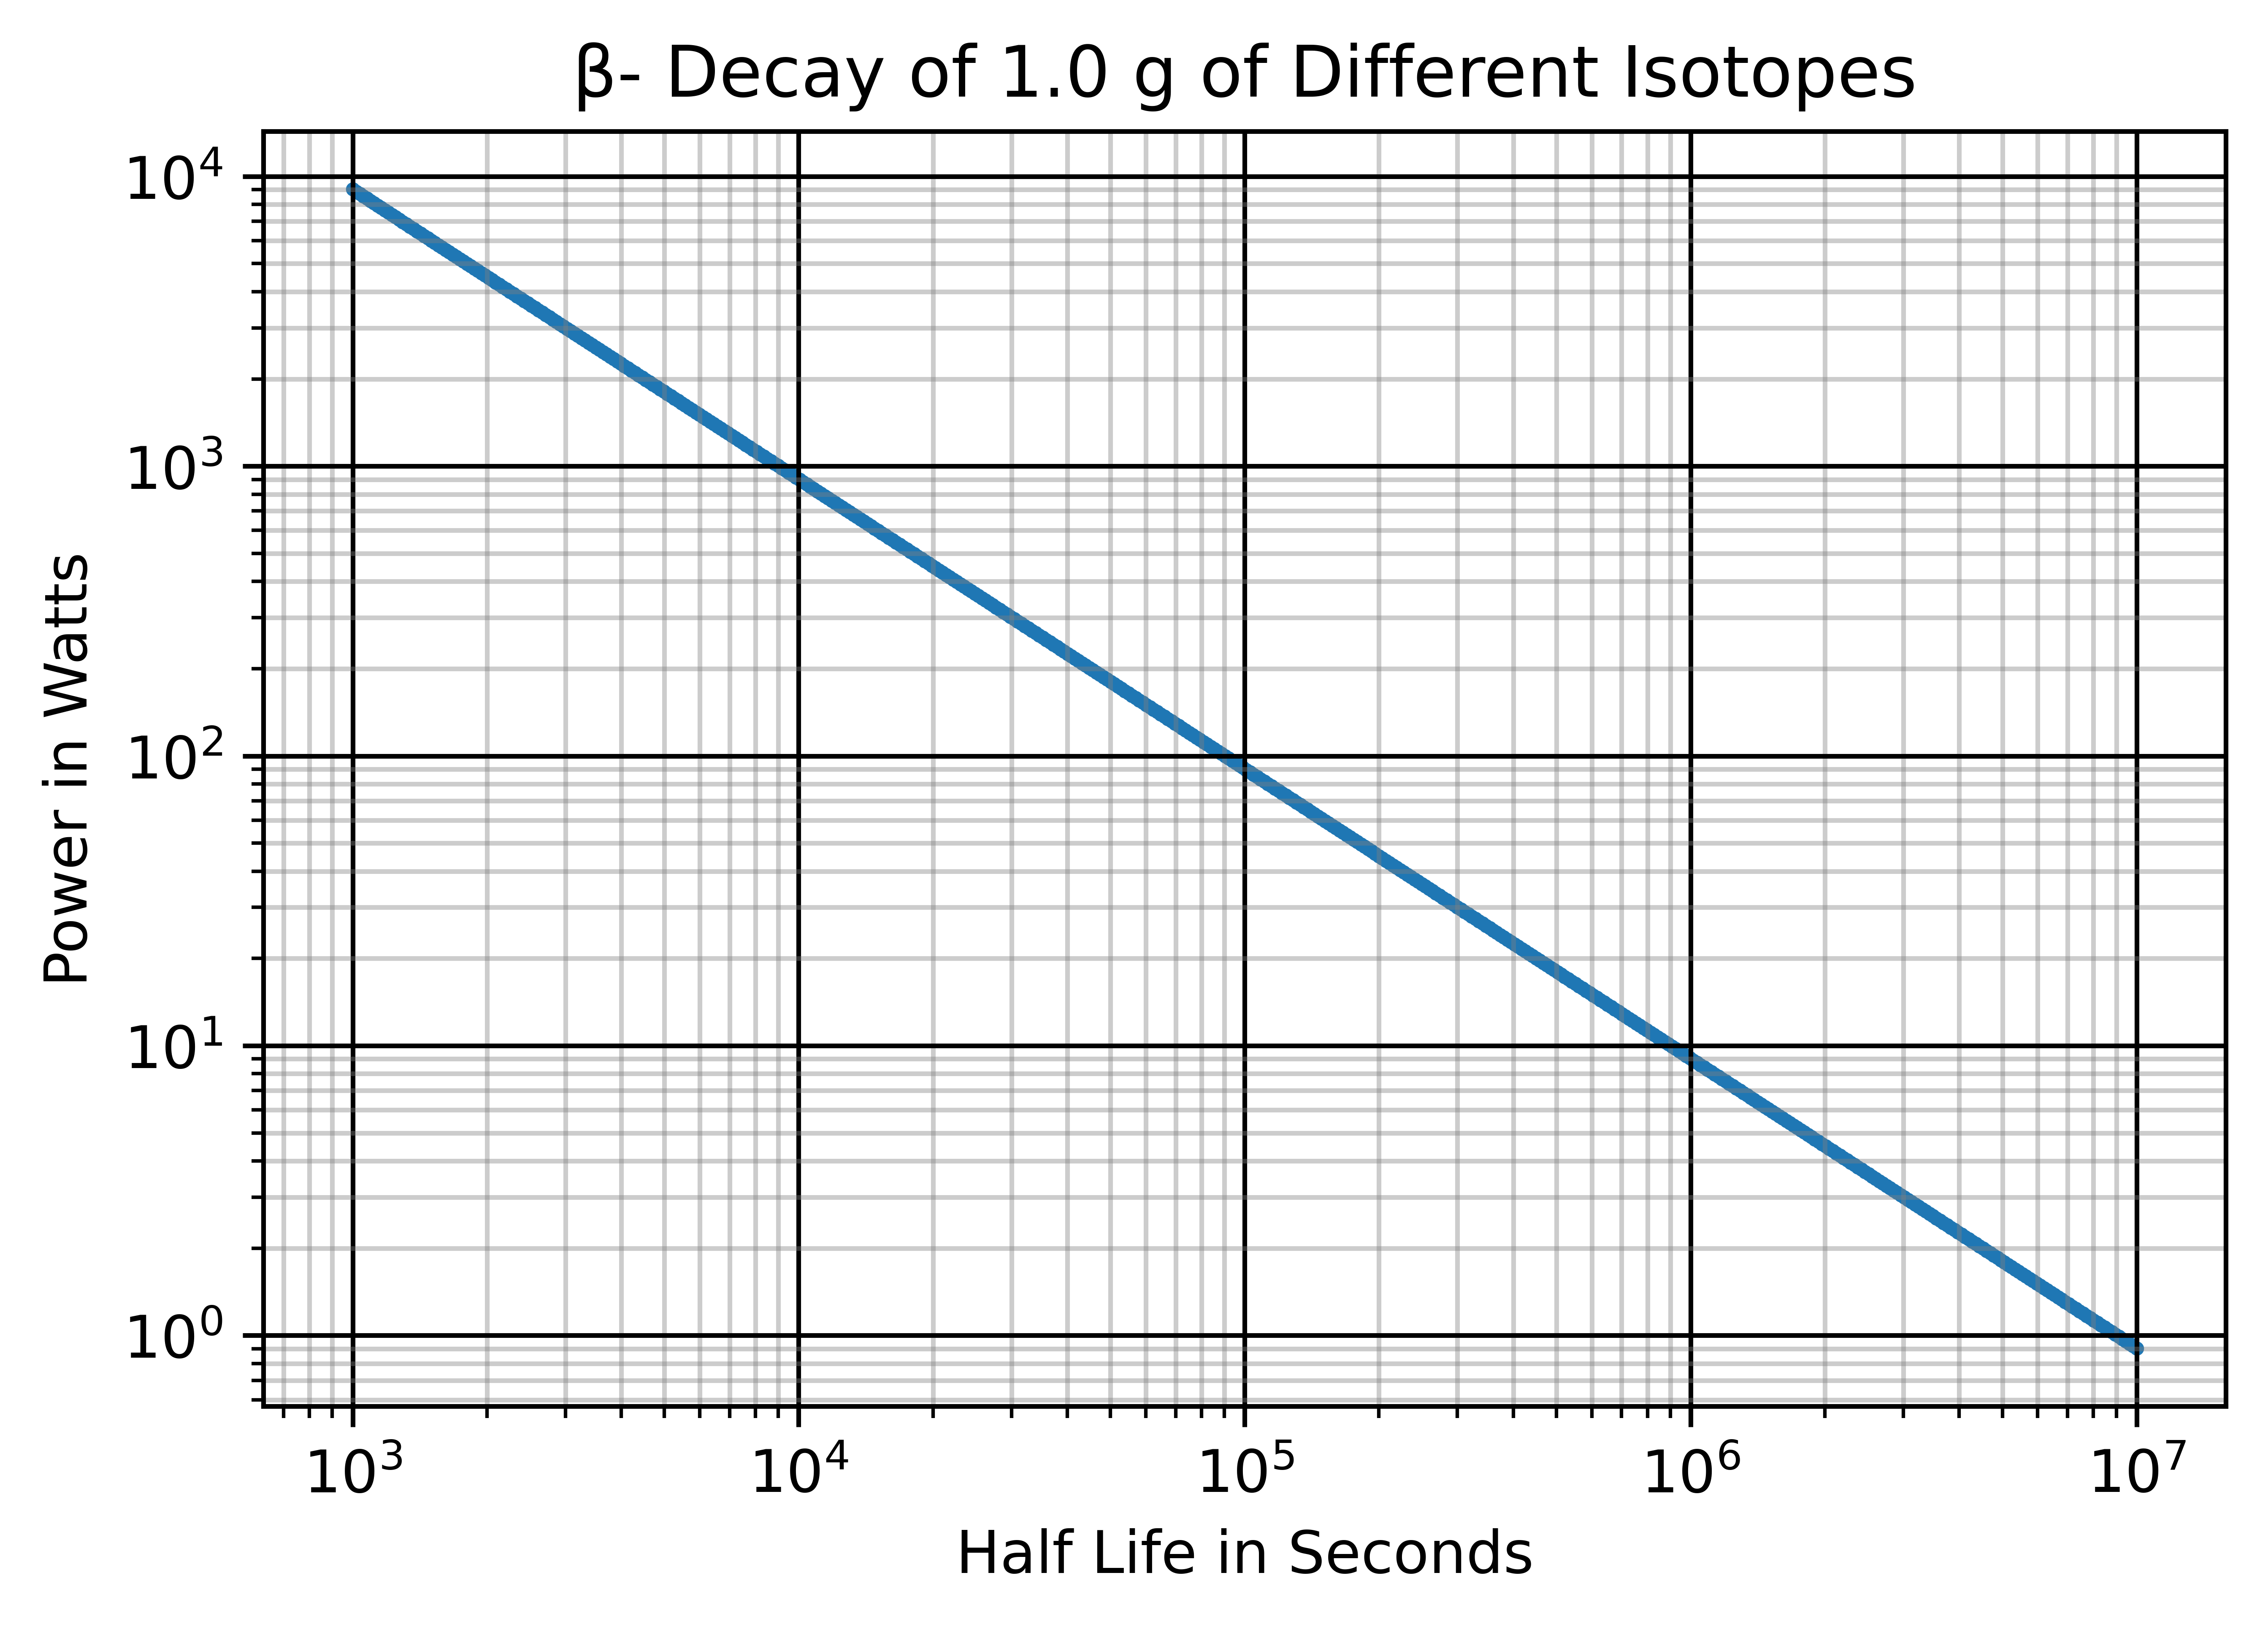

array([-0.9999807 ,  6.95525217])

In [91]:
'''
Interestingly, zooming in we have a half-life of 10^9 seconds (30 years) 
corresponds to about 1 W/g. 
Conveniently, on this log-log graph, the slope is also about -1. 
'''
plot_power_vs_half_life(3, 7, 500, 1, 63, 2, provide_fit = True, dpi = 10**3)

In [92]:
half_life_Si_31 = (157 * units.minute).to(units.s) / units.s
power_Si_31_per_gram = half_life_to_energy(half_life_Si_31, 1, 1, "beta_minus", 
                                  31) * units.W
power_Si_31_per_gram

<Quantity 1946.60177271 W>

In [93]:
half_life_Ni_63 = (100.1 * units.year).to(units.s) / units.s
power_Ni_63_per_gram = half_life_to_energy(half_life_Ni_63, 1, 1, "beta_minus", 
                                  63) * units.W
power_Ni_63_per_gram #200kg could power a car for 50 years :) 

<Quantity 0.00285645 W>

#Power and energy density for each isotope
We will use the above functions and dataframes to calculate the energy and power density of each isotope.

#Background physics 
For the nuclear reaction 
x + X $\to$ y + Y
we define the Q as the energy from \
mass loss:
\begin{equation}
Q = [x_{mass}+X_{mass}-y_{mass}-Y_{mass}]c^2
\end{equation}
For $\beta^-$ decay we have 
\begin{equation}
\begin{split}
n\to p + e^{-} + \bar{v}\\
Q = (n_{mass} - p_{mass} - e^{-}_{mass} - \bar{v}_{mass})c^2\\
Q = .782MeV - \bar{v}_{mass}c^2
\end{split}
\end{equation}
Assuming a massless neutrino this simplifies to .782 MeV

In [94]:
#half_life_to_energy(.987 * 3.1536 * (10 ** 9), 1, 10**-6)[0]
avg_energy_per_decay = 17 * units.keV
mass_predecay = constants.m_n
mass_postdecay = constants.m_p + constants.m_e
Ni63_half_life = 1.02 * 3.1536 * (10 ** 9) * units.s 
time = 1 * units.s
initial_mass = (10 ** -6) * units.kg
recalc_energy_per_decay = (mass_predecay - mass_postdecay) * (constants.c ** 2)
recalc_energy_per_decay.to(units.keV) / avg_energy_per_decay

<Quantity 46.01961235>

#Potential Supply Chain
https://drive.google.com/file/d/1Mhe_WbmmahkeAE_JPnbYRvphh6IAWPwn/view?usp=sharing 

This is very similar to how neutrons are currently produced in particle 
accelerators :)


https://drive.google.com/file/d/1wPwC2eu6CqND1JRK_Dgwao7nJKzyh7Xj/view?usp=sharing 

https://drive.google.com/file/d/1t76jd7mjup9C_4SqJ5opnoNNZjVcNmSs/view?usp=sharing

Thermal neutrons (0.025 eV) are sufficient ([neutron temperature](https://https://en.wikipedia.org/wiki/Neutron_temperature), [Bryskin et al. 2004. Figure 4.](https://www.zotero.org/groups/4549380/batteries/collections/CYLBRLVK/items/T7U9LM8V/collection)) 

In [95]:
class ni63_setup:
  '''
  This will call helper classes depending on the different steps using in the 
  production
  '''
  
  def __init__(self, **kwargs):
    self.assign_attributes(**kwargs)
    self.solar_panel_dict = {}

  def assign_attributes(self, **kwargs):
      for key in kwargs:
          setattr(self, key, kwargs[key])


In [96]:
class solar_panel:
  '''
  Use to create a solar_panel object with a given efficiency, area, and solar flux
  ''' 
  def __init__(self, **kwargs):
    self.assign_attributes(**kwargs)

  def assign_attributes(self, **kwargs):
      for key in kwargs:
          setattr(self, key, kwargs[key])

  def calc_voltage(self):
    '''
    By definition
    power = solar_flux * efficiency * area
    power = voltage * current
    Taking the equivalent resistance of the entire circuit, we have
    voltage = current * resistance
    current = voltage / resistance
    power = voltage^2 / resistance
    voltage = sqrt(power * resistance)
    voltage = sqrt(solar_flux * efficiency * area * resistance)
    ''' 
    voltage =  np.sqrt(self.solar_flux * self.solar_panel_efficiency * 
                         self.solar_panel_area * self.resistance)
    self.voltage = voltage.to(V)

  def calc_charge_plane(self):
  #Modify appropriately for the shape of the capacitor
    self.charge = self.capacitance * self.voltage

  def calc_gamma_ray_flux(self):
    self.gamma_ray_flux = ((self.charge**2) * (self.charge_e_distance**-4) * 
                           self.brehm_coeff * self.cathode_ray_flux)

  def calc_ni63_production_speed(self):
    self.ni63_production_speed = (self.gamma_ray_flux * self.donor_cross_section
                                  * self.target_cross_section)

In [97]:
def calc_brehm_coeff():
  echarge = 1.6021766 * (10 ** -19) * C
  return ((echarge**4) / (96 * ((math.pi * c * 8.8541878128 * (10**-12) * F / m)**3) * 
                    (m_e ** 2)))

def calc_cathode_ray_flux():
  return

In [98]:
'''
https://www.thermofisher.com/order/catalog/product/1517021A 

50 W is sufficient for 10^8 n/s
'''

'\nhttps://www.thermofisher.com/order/catalog/product/1517021A \n\n50 W is sufficient for 10^8 n/s\n'

#Order of Magnitude of time and land area needed

##Theoretical Maximum Production per m$^2$ solar panel

With a power input of $P$ and a $E_{\gamma}$ joules for each gamma ray, assuming
each gamma ray has a $\rho$ probability of producing $^{63}$Ni we have 
\begin{equation}
\begin{split}
N = \frac{P\rho}{E_{\gamma}}\\
\end{split}
\end{equation}

In [99]:
def g_per_year(solar_flux, area, efficiency, energy_per_neutron, molar_mass):
  power = solar_flux * area * efficiency
  nGamma = power / energy_per_neutron
  isotopes_per_second = nGamma.to(units.s ** -1) 
  molPerS = (isotopes_per_second / (constants.N_A)).to(units.mol * units.s ** -1)
  return (molPerS * (molar_mass)).to(units.g * units.year ** -1)

solar_flux = 1000 * units.W / (units.m ** 2)
area = 1 * units.m ** 2
efficiency = 1 #any real world factors that affect the production rate
energy_per_neutron = .075 * units.MeV
molar_mass = 63 * units.g / units.mol
rate = g_per_year(solar_flux, area, efficiency, energy_per_neutron, molar_mass)
rate

<Quantity 274.74003993 g / yr>

##It will take 5,000 years/m$^2$ to make enough for a car to work for 50 years.
We have a theoretical maximum of $10^{-6}$ mol nickel-63 per second for every square meter of sunlight collected per second = 36 moles per year > 2kg. Every car will need 5 years. We need 400 million m$^2$

In [100]:
earth_rad = 6400 * units.km
earth_surface_area = np.pi * 4 * (earth_rad ** 2)
panels_area = 400 * (10**6) * (units.m ** 2)
panels_area.to(units.km ** 2) / earth_surface_area

<Quantity 7.77123746e-07>

##We need to cover 1-millionth of the Earth in solar panels. More realistically, 400 mi$^2$

##Caltech People who have done photoneutron work
*   S.R. Golwala
*   T. Aralis


##What is the energy per gamma ray and probability of Ni63 production needed to make this technology competiting in the long term compared to current forms of energy storage?

The emission of radiation by accelerating charges is derived in Chapter 14 and 
15 of the 2nd edition of Jackson's E&M. 

In [101]:
'''
Source: 
https://www.iea.org/reports/key-world-energy-statistics-2021/final-consumption 
'''
annual_global_energy_consumed = (450 * units.EJ).to(units.W * units.year)
global_power_consumed = annual_global_energy_consumed / (1 * units.year)
efficiency = .2
power_per_area = 500 * units.W / (units.m ** 2) * efficiency
area_needed = (global_power_consumed / power_per_area).to(units.km ** 2)
area_needed

<Quantity 142596.39516313 km2>

In [102]:
global_power_consumed / power_Si_31_per_gram

<Quantity 7.32540148e+09>

In [103]:
global_power_consumed

<Quantity 1.42596395e+13 W>

In [104]:
area_California_state = 423970.694 * (units.km**2)
area_California_state / area_needed

<Quantity 2.97322168>

##If we cover 1/3 of California in solar panels, we could power the world. 

##We need to cover half a million square miles with solar panels and rapidly replant native flora.

In [105]:
#https://doi.org/10.1103/PhysRevX.7.041003
input = 40 * units.PW
Egamma= 2 * units.MeV
max_photon_flux = (input/Egamma).to(units.s ** -1)
max_photon_flux

<Quantity 1.24830181e+29 1 / s>

##Rewrite clas to be based on generating the right energy neutrons for Ni63 production.

In [106]:
frequency = ((2 * units.MeV).to(units.J) / constants.h).to(units.Hz)
frequency 

<Quantity 4.83597848e+20 Hz>

A system that can convert between different isotopes depending on the power demand would be ideal. 


*   Requires a fast, compact, and energy efficient way to convert between emitted electrons and neutrons. 

Possibilities include using the Brehmsstrahlung effect to create gamma rays which can then be used to generate photoneutrons. This seems like the crux of 
the system.

*  



In [107]:
def total_brehmsstrahlung_power(velocity, charge, acceleration):
  '''
  Source: 
  https://en.wikipedia.org/wiki/Bremsstrahlung#Total_radiated_power 
  '''
  beta = velocity / constants.c
  gamma = (1 - (beta ** 2)) ** -.5
  beta_dot = (acceleration / constants.c) 
  beta_term = (beta_dot ** 2) + ((beta * beta_dot) ** 2)/(1 - (beta ** 2)) 
  power = (charge ** 2) * (gamma ** 4) * beta_term / (6 * 
                  float(sym.N(sym.pi)) * constants.eps0 * constants.c)
  return power.to(units.W)

In [108]:
total_brehmsstrahlung_power(.0000001 * constants.c, 1 * constants.e.si, .0000001 * 
                          constants.c / units.s)

<Quantity 5.13038824e-51 W>

In [109]:
total_energy_stored = half_life_Ni_63 * units.s * power_Ni_63_per_gram
total_energy_stored.to(units.TW * units.hour) #underestimate, and also per gram

<Quantity 2.50647118e-09 h TW>

##Using the technology of the Andasol Solar Power Station, an area half the size of Pennsylvania could power the entire world. 

In [110]:
#https://en.wikipedia.org/wiki/Andasol_Solar_Power_Station
andasol = 2000 * units.kW * units.hour / ((units.m ** 2 ) * units.year)
andasol_efficiency = andasol.to(units.W / (units.m ** 2))
andasol_efficiency

<Quantity 228.15423226 W / m2>

In [111]:
needed_area = (global_power_consumed / andasol_efficiency).to(units.km ** 2)
needed_area 

<Quantity 62500. km2>

In [112]:
pennsylvania_area = 119281.9 * (units.km ** 2)
needed_area / pennsylvania_area

<Quantity 0.52396885>

In [113]:
neutrino_mass = (1 * units.keV / (constants.c ** 2)).to(units.g)
neutrino_mass

<Quantity 1.78266192e-30 g>

#Simualted Spectrum Using the Fermi Distribution
[Approximated Energy Spectrum](https://photos.app.goo.gl/gfHG43iBdRp8a59v9 )
\begin{equation}
\begin{split}
N(T_e) = \frac{C}{c^5}(Q - T_e)^2(T + m_ec^2)\sqrt{T_e^2 + 2T_em_ec^2}\\
\end{split}
\end{equation}
Integrating this from 0 to Q and then normalizing the distribution
\begin{equation}
\begin{split}
\int_0^{T_{e \ max}} N(T_e)dT_e\\
\int_0^{T_{e \ max}} \frac{C}{c^5}(Q - T_e)^2(T_e + m_ec^2)\sqrt{T_e^2 + 2T_em_ec^2} dT_e = 1\\
C = \frac{c^5}{\int_0^{Q} (Q - x)^2(x + a)\sqrt{x^2 + 2a} dx}\\
\end{split}
\end{equation}
For some reason, [WolframAlpha](https://www.wolframalpha.com/input?i=%5Cint_0%5E%7BQ%7D+%28Q+-+x%29%5E2%28x+%2B+a%29%5Csqrt%7Bx%5E2+%2B+2a%7D+dx)
won't evaluate the integral. So using sympy, where Q = .782 MeV, a = m$_e$c$^2$,
and $x = T_e$
All units are in kg-m-s SI.

In [114]:
Q_fermi_distr = float((.782 * units.MeV).to(units.J) / units.J)
Q_fermi_distr

1.252902127788e-13

In [115]:
unnormalized_fermi_fun = ((Q - x) ** 2) * (x + a) * sym.sqrt(
    (x ** 2) + (2 * a))
denominator = sym.integrate(unnormalized_fermi_fun, (x, 0, sym.oo))

In [116]:
a_fermi_distr = float((constants.m_e * (constants.c ** 2)).to(units.J) 
/ units.J)
a_fermi_distr

8.187105776823886e-14

In [117]:
c_to_the_fifth = float((constants.c * units.s / units.m) ** 5)
c_to_the_fifth

2.4216061708512208e+42

In [118]:
integrated_dist = sym.lambdify((Q, a), denominator)
fermi_distr_const = c_to_the_fifth / integrated_dist(Q_fermi_distr, 
                                                     a_fermi_distr)

In [119]:
fermi_distr_fun = C * unnormalized_fermi_fun / c_to_the_fifth
fermi_distr = sym.lambdify((Q, a, C, x), fermi_distr_fun)

electron_energies = []
abundance = []
log_res = 3
for electron_energy in np.linspace(0, Q_fermi_distr, 10 ** log_res):
  abundance.append(fermi_distr(Q_fermi_distr, a_fermi_distr, 
                               fermi_distr_const, electron_energy))
  electron_energy_keV = float((electron_energy * units.J).to(units.keV) 
        / units.keV)
  electron_energies.append(electron_energy_keV)
xlabel, ylabel = 'Electron Energy in keV', 'Abundance in Counts' 
data = {xlabel: electron_energies, ylabel: abundance}
Ni63_spectrum = pd.DataFrame.from_dict(data)
fig = px.scatter(Ni63_spectrum, x = xlabel, y = ylabel)
fig.show()

In [120]:
fermi_distr_fun

4.12949063327043e-43*C*(Q - x)**2*(a + x)*sqrt(2*a + x**2)

In [121]:
average_fun = (sym.integrate(fermi_distr_fun, (x, 0, fermi_distr_fun)) / 
           fermi_distr_fun)
average = sym.lambdify((Q, a, C, x), average_fun)
average(Q_fermi_distr, a_fermi_distr, fermi_distr_const, Q_fermi_distr)

<string>:2: RuntimeWarning:

invalid value encountered in double_scalars



nan

In [122]:
def normalized_counts(T_e, Q):
  count = (np.sqrt(((T_e **  2) + 2 * (T_e * m_e * (c ** 2)))) 
            * ((Q - T_e) ** 2) * (T_e + m_e * (c ** 2)) / (c ** 5))
  return count

In [123]:
fermi_distr_const

0.0

In [124]:

'''
We need to account for the fact that not all of the electrons will have the 
maximum energy (Q value)!
stuck for right now. Use
https://github.com/MarcosP7635/Computing-and-Formatting/blob/main/error_propagation.py
as a sympy reference
They average out to 17 keV. Rewrite to draw from a database of beta emission 
spectra. 
'''

'\nWe need to account for the fact that not all of the electrons will have the \nmaximum energy (Q value)!\nstuck for right now. Use\nhttps://github.com/MarcosP7635/Computing-and-Formatting/blob/main/error_propagation.py\nas a sympy reference\nThey average out to 17 keV. Rewrite to draw from a database of beta emission \nspectra. \n'

In [125]:
global_power_consumed

<Quantity 1.42596395e+13 W>

In [126]:
energy_Ni_63_per_gram = (power_Ni_63_per_gram * 50 * units.year).to(units.J)
'''
The best lithium-ion batteries store less than 1 kJ/g
Source: https://doi.org/10.1039/D0EE02681F 
'''
energy_Ni_63_per_gram 

<Quantity 4507140.97686537 J>

In [128]:
'''
if google drive won't mount to the colab session, then
you need to download this current python notebook and upload
it to the colab session, then right click on it to copy the
path for the command below.
'''
!jupyter nbconvert --to LaTeX /content/Energy.ipynb
#The above line makes a .tex file to format this Jupyter Notebook

[NbConvertApp] Converting notebook /content/Energy.ipynb to LaTeX
/usr/local/lib/python3.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
/usr/local/lib/python3.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Support files will be in Energy_files/
[NbConvertApp] Making directory /content/Energy_files
[NbConvertApp] Making directory /content/Energy_files
[NbConvertApp] Writing 125692 bytes to /content/Energy.tex
